# Experiment on Cluster TSD Trend
Notebook to perform some model on a single TSD Trend Cluster: trhougth time-series-decomposition, the trend inside the cluster is extracted and used to make prediction.<br>
Data read are from table SLIDING_WINDOWS_DATASET that contains a sliding windows of:
- feats about last 7-days meteo values
- pollen value for the next day

Cluster associations are read from a local file: we have different cluster annotations made by different techniques.<br>
We explore different model & hyper-parameters throught Comet ML.

<h3>Import</h3>

In [1]:
from tqdm.auto import tqdm
import json
import math
import os
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
from google.cloud import bigquery

import seaborn as sns
from collections import Counter
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
import scipy.stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_error
from plotly.offline import init_notebook_mode, iplot

from comet_ml import Experiment

import tensorflow as tf
from keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers.experimental import Adam, AdamW, Adadelta
from statsmodels.tsa.seasonal import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

my_cmap = plt.get_cmap("Paired")
init_notebook_mode(connected=True)  
tqdm.pandas()

2023-05-12 11:08:01.324081: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<h3>Config</h3>

In [2]:
# Config

PROJECT_ID = 'arpae-prod-ml'

# BigQuery
BQ_DATASET = 'SAMPLE_DATA'
JOINED_BQ_DATASET = 'JOINED_DATA'

# Const
COMMON_PERIOD_INIT = '2011-01-01'
COMMON_PERIOD_END = '2023-12-31' 

TRAIN_END = '2016-12-31 00:00:00+00:00'
VAL_END = '2019-12-31 00:00:00+00:00'
TEST_END = '2022-12-31 00:00:00+00:00'

# Cols
DATE_COL = 'date'

# Feats
METEO_FEATS = ['week_amax', 
               'station_lat_amax', 'station_lon_amax', 'station_H_piano_strada_amax', 'station_H_mslm_amax', 
               'B13011_min_amin', 'B13011_max_amax', 'B13011_mean_mean', 'B13011_std_mean', 'B13011_sum_sum', 
               'B14198_min_amin', 'B14198_max_amax', 'B14198_mean_mean', 'B14198_std_mean', 'B14198_sum_sum',
               'TEMP_min_amin', 'TEMP_max_amax', 'TEMP_mean_mean', 'TEMP_std_mean', 'TEMP_sum_sum',                                               
               'PREC_amin', 'PREC_mean', 'PREC_std', 'PREC_median', 'PREC_amax', 'PREC_skew', 'PREC_kurtosis']
POLLEN_FEATS = ['trend_mean', 'trend_prev_1', # seasonal, trend, residual
                'pol_value_amin', 'pol_value_mean', 'pol_value_std', 'pol_value_median', 'pol_value_amax', 
                'pol_value_skew', 'pol_value_kurtosis',
                'pol_value_prev_1', 'pol_value_prev_2', 'pol_value_prev_3',
                'pol_value_prev_4', 'pol_value_prev_5', 'pol_value_prev_6',
                'pol_value_prev_7']
ORIGINAL_FEATS = METEO_FEATS + POLLEN_FEATS
LABEL_COL = 'trend_label' # season, trend, residual

# Params
EPOCHS = 50

# Comet Params
COMET_API_KEY = 'B4Tttbbx4JrwXD9x2HBNjCdXX'
COMET_WORKSPACE = 'pveronesi' 
COMET_PROJECT_NAME = 'arpae-tsd-trend-experiments' # season, trend, residual

# Layout
COLOR_PALETTE = px.colors.qualitative.Prism

OUTPUT_CLUSTER_FILENAME = "../../data/clustering_trend_intervals.csv" # season, trend, residual
OPT_PARAMS_FILENAME = "../../data/optimal_params_trend.csv" # season, trend, residual
MODEL_DIR = "../../models/trend/" # season, trend, residual


<h3>Methods</h3>

In [3]:
# Read Methods

def _run_query(client, query): 
    df = client.query(query).to_dataframe()
    return df

def _read_table(client, project_id, dataset, table):
    query = "SELECT * FROM `{}.{}.{}` ".format(project_id, dataset, table)
    df = _run_query(client, query)
    return df

def _read_table_delta(client, project_id, dataset, table, date_col, init, end):
    query = "SELECT * FROM `{}.{}.{}` WHERE {} > '{}' AND {} < '{}' ".format(project_id, dataset, table, date_col, init, date_col, end)
    df = _run_query(client, query)
    if 'reftime' in df.columns:
        df.sort_values(by='reftime', inplace=True)
    elif date_col in df.columns:
        df.sort_values(by=date_col, inplace=True)
    else:
        return None
    return df


In [4]:
# Comet methods

def _create_experiment(api_key, workspace, project_name):
    experiment = Experiment(
        # user config
        api_key=api_key,
        workspace=workspace,  
        # project config
        project_name=project_name,
        # logging config
        log_code=True,
        log_graph=True,
        auto_param_logging=True,
        auto_metric_logging=True,    
        auto_histogram_weight_logging=True,
        auto_histogram_gradient_logging=True,
        auto_histogram_activation_logging=True
    )
    return experiment

In [5]:
# Process Methods

def _create_experiment_widget():
    exp_wdgt = widgets.Dropdown(options=['Opt Params', 'Manual Params'], description='Set Params:', layout={"width":"50%"})
    return exp_wdgt

def _create_cluster_widget(clusters):
    cluster_wdgt = widgets.Dropdown(options=clusters, description='Cluster id:', layout={"width":"50%"})
    return cluster_wdgt

def _normalize(x, range_dict, index_col, label_col):
    pol_min = range_dict[x[index_col]]['min']
    pol_max = range_dict[x[index_col]]['max']
    return (x[label_col] - pol_min) / (pol_max - pol_min)


In [6]:
# Data Methods

def _get_data(data_df, clusters_df, cluster_id, feats_cols, date_col, label_col):
    # filter data
    filt_clusters_df = clusters_df[clusters_df['cluster']==cluster_id][['station_id', 'pol_var_id']]
    dataset_df = pd.merge(data_df, filt_clusters_df, how='right', on=['station_id', 'pol_var_id'])
    
    # Create dataset
    dataset_df.sort_values(['station_id', 'pol_var_id', date_col], inplace=True)
    dataset_df = dataset_df[['station_id', 'pol_var_id', date_col]  + feats_cols + [label_col]]
    
    # Set index and drop nan
    dataset_df.set_index(date_col, inplace=True)
    dataset_df.dropna(inplace=True)
    
    print("Rows: {}".format(dataset_df.shape[0]))
    return dataset_df

def _prepare_data(dataset_df, original_feats, meteo_feats, pollen_feats, label_col):
    # Add 1-hot encoding cols
    stations_one_hot = pd.get_dummies(dataset_df['station_id'], prefix='station_id')
    pollen_one_hot = pd.get_dummies(dataset_df['pol_var_id'], prefix='pol_var_id')
    dataset_df = pd.concat([dataset_df, stations_one_hot], axis=1)
    dataset_df = pd.concat([dataset_df, pollen_one_hot], axis=1)
    
    # Update Features
    feats = original_feats + stations_one_hot.columns.values.tolist() + pollen_one_hot.columns.values.tolist()
    n_feats = len(feats)
    
    # Normalize all cols except for pollen ones; Save max cols to restore original values
    cols_max = []
    for col in meteo_feats:
        scaler = MinMaxScaler()
        dataset_df[col] = pd.DataFrame(scaler.fit_transform(dataset_df[[col]])).values
        cols_max.append(int(scaler.data_max_))

    # Normalize with Min-Max scaling each pollen feats 
    for col in tqdm(pollen_feats):
        range_df = dataset_df[['pol_var_id', col]].groupby('pol_var_id').agg(['min', 'max'])
        ranges = {}
        for index, values in zip(range_df.index, range_df.values):
            ranges[index] = {'min': values[0], 'max': values[1]}        
        dataset_df[col] = dataset_df.apply(lambda x: _normalize(x, ranges, 'pol_var_id', col), axis=1)    
    
    # Normalize with Min-Max scaling the label col
    range_df = dataset_df[['pol_var_id', LABEL_COL]].groupby('pol_var_id').agg(['min', 'max'])
    ranges = {}
    for index, values in zip(range_df.index, range_df.values):
        ranges[index] = {'min': values[0], 'max': values[1]}        
    dataset_df[label_col] = dataset_df.apply(lambda x: _normalize(x, ranges, 'pol_var_id', label_col), axis=1)    
    
    # Sort data
    dataset_df.index = pd.to_datetime(dataset_df.index)
    dataset_df.sort_values(by=['station_id', 'pol_var_id', 'date'], inplace=True)

    return dataset_df, feats, n_feats, cols_max

def _create_datasets(dataset_df, train_end, val_end, test_end, feats, label_col, sequence_len, batch_size):
    # Split df into train and test sets
    train_df = dataset_df[dataset_df.index < pd.to_datetime(train_end)]
    val_df = dataset_df[(dataset_df.index > pd.to_datetime(train_end)) & 
                        (dataset_df.index < pd.to_datetime(val_end))]
    test_df = dataset_df[(dataset_df.index > pd.to_datetime(val_end)) & 
                         (dataset_df.index < pd.to_datetime(test_end))]
    print("Train dataset: {}, Val dataset: {}, Test dataset: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))
    
    # Split into feats and labels
    train_X, train_y = train_df[feats].values, train_df[label_col]
    val_X, val_y = val_df[feats].values, val_df[label_col]
    test_X, test_y = test_df[feats].values, test_df[label_col]

    # Create Sliding-Windows Dataset
    train_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(train_X,
                                                                         train_y,
                                                                         sequence_length=sequence_len,
                                                                         batch_size=batch_size)
    val_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(val_X,
                                                                       val_y,
                                                                       sequence_length=sequence_len,
                                                                       batch_size=batch_size)
    test_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(test_X,
                                                                        test_y,
                                                                        sequence_length=sequence_len,
                                                                        batch_size=batch_size)
    
    return train_dataset, val_dataset, test_dataset, test_df


In [7]:
# Model Methods

def _lstm_base_model(sequence_len, n_feats):
    input_layer = tf.keras.layers.Input(shape=(sequence_len, n_feats))
    x = tf.keras.layers.LSTM(units=128, 
                                  dropout=0.4, 
                                  return_sequences=True)(input_layer)
    x = tf.keras.layers.LSTM(units=128, 
                                  dropout=0.4, 
                                  return_sequences=True)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    x = tf.keras.layers.Dense(units=128)(x)
    x = tf.keras.layers.Dropout(0.4)(x)
    output_layer = tf.keras.layers.Dense(units=1)(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer) 
    return model

def _lstm_attention_model(sequence_len, n_feats, dropout, layer_lstm_1_units, layer_lstm_2_units, 
                          layer_dense_units):
    input_layer = tf.keras.layers.Input(shape=(sequence_len, n_feats))
    x = tf.keras.layers.LSTM(units=layer_lstm_1_units, 
                                  dropout=dropout, 
                                  return_sequences=True)(input_layer)
    x = tf.keras.layers.LSTM(units=layer_lstm_2_units, 
                                  dropout=dropout, 
                                  return_sequences=True)(x)
    x = tf.keras.layers.MultiHeadAttention(num_heads=8, key_dim=64)(query=x, value=x, key=x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Dense(units=layer_dense_units)(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    output_layer = tf.keras.layers.Dense(units=1)(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer) 
    return model

# Losses Methods

def _compile_mse_model(model):
    model.compile(loss='mse', optimizer='adam')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    model.summary()
    return model, early_stop

def _compile_adamw_mse_model(model, learning_rate, weight_decay):
    # AdamW 
    optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    model.compile(loss='mse', optimizer=optimizer)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    model.summary()
    return model, early_stop

def _compile_adadelta_mse_model(model, learning_rate, rho):
    # Adadelta is based on adaptive learning rate
    optimizer = Adadelta(learning_rate=learning_rate, rho=rho)
    model.compile(loss='mse', optimizer=optimizer)
    early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)
    model.summary()
    return model, early_stop

# Training Methods

def _fit_model(model, epochs, train_dataset, val_dataset, callbacks):    
    history = model.fit(train_dataset, 
                        epochs=epochs,
                        validation_data=val_dataset, 
                        verbose=1, 
                        callbacks=callbacks,
                        shuffle=True)
    return history

def _run_experiment(comet_api_key, comet_workspace, comet_project, data_df, clusters_df,
                    cluster_id, tag,
                    model_name, batch_size, sequence_len, loss, learning_rate, weight_decay, rho, epochs,
                    dropout, layer_lstm_1_units, layer_lstm_2_units, layer_dense_units,
                    original_feats, meteo_feats, pollen_feats, date_col, label_col,
                    train_end, val_end, test_end):
    # Run Experiment
    model_id = "{}-Batch{}-SeqLen{}-Loss{}-Cluster{}".format(model_name, batch_size, sequence_len, 
                                                             loss, cluster_id)
    experiment = _create_experiment(comet_api_key, comet_workspace, comet_project)
    experiment.set_name(model_id)
    experiment.add_tag(tag)
    print("Running Experiment {}:".format(model_id))

    # Get Data
    print("\nGetting data..")
    dataset_df = _get_data(data_df, clusters_df, cluster_id, original_feats, date_col, label_col)    

    # Prepare Data
    print("\nPreparing data..")
    dataset_df, feats, n_feats, cols_max = _prepare_data(dataset_df, original_feats, meteo_feats, 
                                                         pollen_feats, label_col)

    # Create Dataset
    print("\nCreating dataset..")
    train_dataset, val_dataset, test_dataset, test_df = _create_datasets(dataset_df, train_end, val_end, 
                                                                         test_end, feats, label_col, 
                                                                         sequence_len, batch_size)

    # Define Model
    print("\nDefining & Training model..")
    if model_name == 'LSTM_base':
        model = _lstm_base_model(sequence_len, n_feats)
    elif model_name == 'LSTM_Attention_v1':
        model = _lstm_attention_model(sequence_len, n_feats, dropout, layer_lstm_1_units, layer_lstm_2_units, 
                                      layer_dense_units)
    else:
        pass

    # Compile Model
    if loss == 'ADAM_MSE':
        model, early_stop = _compile_mse_model(model)
    elif loss == 'ADAMW_MSE':
        model, early_stop = _compile_adamw_mse_model(model, learning_rate, weight_decay)
    elif loss == 'ADADELTA_MSE':
        model, early_stop = _compile_adadelta_mse_model(model, learning_rate, rho)
    else:
        pass

    # Train Model
    history = _fit_model(model, epochs, train_dataset, val_dataset, [early_stop])

    # Get Error on test-set
    preds, error = _get_error(model, test_dataset)
    experiment.log_other("test-error", error)
    print("Final Error: {}".format(error))

    # Save Model (locally and on comet)
    model_path = os.path.join(MODEL_DIR, model_id)
    print("Saving Model on {} ..".format(model_path))
    model.save(model_path)
    experiment.log_model(model_id, model_path)
    
    # End experiment
    experiment.end()
    
    return history, test_dataset, test_df, preds, error, feats

In [8]:
# Evaluation Methods

def _get_error(model, test_dataset):
    preds = model.predict(test_dataset).squeeze()
    truth = []
    for x, y in test_dataset:
        truth.extend(y.numpy())
    error = np.mean(np.abs(preds-np.array(truth)))
    return preds, error

def _feats_importances(test_dataset, feats, sequence_len):
    # Get baseline error
    feats_imp = []
    ff_preds = model.predict(test_dataset, verbose=0).squeeze()
    ff_x, ff_y = [], []
    for x, y in test_dataset:
        ff_x.extend(x.numpy())
        ff_y.extend(y.numpy())
    ff_x, ff_y = np.array(ff_x), np.array(ff_y)
    baseline_error = np.mean(np.abs(ff_preds-np.array(ff_y)))
    feats_imp.append({'feature':'BASELINE','mae': baseline_error})
    
    # Get features gain on reducing error: each value 
    for k in tqdm(range(len(feats))):
        # Change values for current feat
        save_col = ff_x[:,:,k].copy()
        ff_x[:,:,k] = [-100 for x in range(sequence_len)]
        # Compute error 
        oof_preds = model.predict(ff_x, verbose=0).squeeze() 
        mae = np.mean(np.abs(oof_preds-ff_y))
        feats_imp.append({'feature': feats[k],'mae': mae})
        ff_x[:,:,k] = save_col
    
    # Plot 
    df = pd.DataFrame(feats_imp)
    df = df.sort_values('mae')
    plt.figure(figsize=(10, 13))
    plt.barh(np.arange(len(feats)+1), df.mae)
    plt.yticks(np.arange(len(feats)+1), df.feature.values)
    plt.title('LSTM Feature Importance', size=16)
    plt.ylim((-1, len(feats)+1))
    plt.plot([baseline_error, baseline_error], [-1,len(feats)+1], '--', color='orange',
             label=f'Baseline OOF\nMAE={baseline_error:.3f}')
    plt.xlabel('MAE with feature permuted', size=14)
    plt.ylabel('Feature', size=14)
    plt.legend()
    plt.show()
    
def _plot_history(history):
    plt.figure(figsize=(15, 5))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
def _plot_preds(preds, test_df, label_col):
    # Predict & Assign to test_df: add values for missing days in preds
    for i in range(len(preds), test_df.shape[0]):
        preds = np.append(preds, 0.0)
    test_df['preds'] = preds
    # Plot some station & bcode
    N_SAMPLE = min(10, test_df[['station_id', 'pol_var_id']].drop_duplicates().shape[0])
    for station_id, pol_var_id in test_df[['station_id', 'pol_var_id']].drop_duplicates().sample(N_SAMPLE).values:
        curr_test_df = test_df[(test_df['station_id']==station_id) & (test_df['pol_var_id']==pol_var_id)]
        curr_test_df.sort_index(inplace=True)
        plt.figure(figsize=(15, 5))
        plt.title("{} - {}".format(station_id, pol_var_id))
        plt.plot(curr_test_df.index, curr_test_df['preds'], label='pred')
        plt.plot(curr_test_df.index, curr_test_df[label_col], label='truth')
        plt.ylim(0, 1)
        plt.legend()
        plt.show()


<h3>1. Config</h3>

<h4>1.1 Config BigQuery</h4>

In [9]:
# Setup Client

bq_client = bigquery.Client(project=PROJECT_ID)
bq_client

<h3>2. Read Data</h3>

<h4>2.1 Read Cluster file</h4>

In [10]:
clusters_df = pd.read_csv(OUTPUT_CLUSTER_FILENAME)
print(clusters_df.shape)
clusters_df.head(3)

(363, 3)


,station_id,pol_var_id,cluster
0,1,B48001,4
1,1,B48002,3
2,1,B48003,0


<h4>2.2 Read Optimal Params (if setted)</h4>

In [11]:
if not os.path.exists(OPT_PARAMS_FILENAME):
    print("Params File Not Found.")    

params_df = pd.read_csv(OPT_PARAMS_FILENAME)
params_df['dropout'] = params_df['dropout'].apply(lambda x: 0.9 if x==1.0 else x)
print(params_df.shape)
params_df

(10, 11)


,cluster_id,model_name,exp_id,batch_size,dropout,layer_dense_units,layer_lstm_1_units,layer_lstm_2_units,learning_rate,sequence_len,test_error
0,0,LSTM_Attention_v1,2,1024,0.1,64,512,256,0.0023,7,0.0520
1,1,LSTM_Attention_v1,8,1024,0.6,128,256,128,0.0068,21,0.0699
2,2,LSTM_Attention_v1,4,256,0.9,512,128,64,0.0485,7,0.1165
3,3,LSTM_Attention_v1,7,512,0.8,128,256,128,0.0214,21,0.1345
4,4,LSTM_Attention_v1,9,1024,0.1,64,128,64,0.0017,14,0.0337
5,5,LSTM_Attention_v1,1,1024,0.8,256,512,512,0.0011,21,0.0594
6,6,LSTM_Attention_v1,2,256,0.7,512,64,128,0.0634,21,0.0000
7,7,LSTM_Attention_v1,1,1024,0.5,64,64,512,0.0487,21,0.0000
8,8,LSTM_Attention_v1,2,256,0.8,64,128,64,0.0336,14,0.1287
9,9,LSTM_Attention_v1,8,256,0.8,256,512,64,0.0729,7,0.0790


<h4>2.2 Read Tables</h4>

<b>SLIDING_WINDOWS_DATASET</b> joins meteo features of last 7-days with the next-day pollen value.

In [12]:
# Read SLIDING_WINDOWS_DATASET

sliding_windows_dataset_df = _read_table_delta(bq_client, PROJECT_ID, JOINED_BQ_DATASET, 
                                               "SLIDING_WINDOWS_DATASET", "date",
                                               COMMON_PERIOD_INIT, COMMON_PERIOD_END)
sliding_windows_dataset_df['date'] = sliding_windows_dataset_df['date'].astype("str")
print(sliding_windows_dataset_df.shape)
sliding_windows_dataset_df.head(3)

(826748, 100)


,date,station_id,pol_var_id,date_diff,B13011_min_amin,B13011_max_amax,B13011_mean_mean,B13011_std_mean,B13011_sum_sum,B14198_min_amin,...,pol_var_id_B48033,pol_var_id_B48034,pol_var_id_B48036,pol_var_id_B48037,pol_var_id_B48038,pol_var_id_B48039,pol_var_id_B48041,pol_var_id_B48044,pol_var_id_B48045,WHICH
325156,2011-01-02 00:00:00+00:00,2,B48008,15,0.0,8.8,0.011261,0.108532,13.4,-10.0,...,0,0,0,0,0,0,0,0,0,training
314359,2011-01-02 00:00:00+00:00,1,B48034,7,0.0,12.6,0.014790,0.148225,17.6,-9.0,...,0,1,0,0,0,0,0,0,0,training
590215,2011-01-02 00:00:00+00:00,13,B48003,10,0.0,2.4,0.004450,0.039220,3.8,-8.0,...,0,0,0,0,0,0,0,0,0,training


<h3>3. Run Experiment</h3>

<h4>3.1 Config Experiment</h4>

In [13]:
# Set data

data_df = sliding_windows_dataset_df.copy()

In [14]:
# Get Clusters

clusters = sorted(clusters_df.cluster.unique())

clusters = [8, 9]

print("Found {} clusters in data".format(len(clusters)))

Found 2 clusters in data


<h4>3.2 Set Params</h4>

Set:
- <b>Manual Params</b>: to use the params setted in the code
- <b>Opt Params</b>: to read the optimal params from the output file after hyper-params tuning has run.

In [15]:
# Set Params

exp_wdgt_value = _create_experiment_widget()
exp_wdgt_value

Dropdown(description='Set Params:', layout=Layout(width='50%'), options=('Opt Params', 'Manual Params'), value…

<h4>3.3 Run Experiment</h4>

In [16]:
# Default Params

DEFAULT_CLUSTER_ID = 0
DEFAULT_BATCH_SIZE = 512               
DEFAULT_SEQUENCE_LEN = 7
DEFAULT_LEARNING_RATE = 0.001
DEFAULT_WEIGHT_DECAY = 0.004
DEFAULT_RHO = 0.95
DEFAULT_EPOCHS = 50
DEFAULT_MODEL_NAME = 'LSTM_Attention_v1'  # LSTM_base, LSTM_Attention_v1
DEFAULT_LOSS = 'ADAM_MSE'                 # ADAM_MSE, ADAMW_MSE, ADADELTA_MSE

DEFAULT_DROPOUT = 0.4
DEFAULT_LAYER_LSTM_1_UNITS = 128
DEFAULT_LAYER_LSTM_2_UNITS = 128
DEFAULT_LAYER_DENSE_UNITS = 128

In [17]:
results = {}

if exp_wdgt_value.value == 'Manual Params':
    # Set params
    TAG = ""
    sample_cluster_id = DEFAULT_CLUSTER_ID
    model_name = DEFAULT_MODEL_NAME
    batch_size = DEFAULT_BATCH_SIZE
    sequence_len = DEFAULT_SEQUENCE_LEN
    learning_rate = DEFAULT_LEARNING_RATE
    weight_decay = DEFAULT_WEIGHT_DECAY
    rho = DEFAULT_RHO    
    loss = DEFAULT_LOSS
    epochs = DEFAULT_EPOCHS
    dropout = DEFAULT_DROPOUT
    layer_lstm_1_units = DEFAULT_LAYER_LSTM_1_UNITS
    layer_lstm_2_units = DEFAULT_LAYER_LSTM_2_UNITS
    layer_dense_units = DEFAULT_LAYER_DENSE_UNITS    
    # Run experiment
    history, test_dataset, test_df, preds, error, feats = _run_experiment(COMET_API_KEY, COMET_WORKSPACE, 
                                                                          COMET_PROJECT_NAME, data_df, 
                                                                          clusters_df, sample_cluster_id, TAG, 
                                                                          model_name, batch_size, sequence_len, 
                                                                          loss, learning_rate, weight_decay, rho,
                                                                          epochs, 
                                                                          dropout, layer_lstm_1_units, 
                                                                          layer_lstm_2_units, layer_dense_units,
                                                                          ORIGINAL_FEATS, 
                                                                          METEO_FEATS, POLLEN_FEATS, DATE_COL, 
                                                                          LABEL_COL, TRAIN_END, VAL_END, TEST_END)
    # Save results
    results[sample_cluster_id] = {
        'history': history,
        'test_dataset': test_dataset, 
        'test_df': test_df, 
        'preds': preds, 
        'error': error,
        'feats': feats
    }
    print("Done.")
    
elif exp_wdgt_value.value == 'Opt Params':
    # For each cluster
    for cluster_id in clusters:
        print("Running Cluster_id: {}".format(cluster_id))
        TAG = "OPT"        
        # Get Cluster Opt params
        params = params_df[params_df['cluster_id']==cluster_id]
        model_name = params['model_name'].values[0]
        batch_size = params['batch_size'].values[0]
        sequence_len = params['sequence_len'].values[0]
        learning_rate = params['learning_rate'].values[0]
        weight_decay = DEFAULT_WEIGHT_DECAY
        rho = DEFAULT_RHO
        loss = DEFAULT_LOSS
        epochs = DEFAULT_EPOCHS     
        dropout = params['dropout'].values[0]
        layer_lstm_1_units = params['layer_lstm_1_units'].values[0]
        layer_lstm_2_units = params['layer_lstm_2_units'].values[0]
        layer_dense_units = params['layer_dense_units'].values[0]    
        # Run experiment
        history, test_dataset, test_df, preds, error, feats = _run_experiment(COMET_API_KEY, COMET_WORKSPACE, 
                                                                              COMET_PROJECT_NAME, data_df, 
                                                                              clusters_df, cluster_id, TAG,
                                                                              model_name, batch_size, 
                                                                              sequence_len, loss, learning_rate, 
                                                                              weight_decay, rho, epochs,
                                                                              dropout, layer_lstm_1_units, 
                                                                              layer_lstm_2_units, 
                                                                              layer_dense_units,
                                                                              ORIGINAL_FEATS, METEO_FEATS, 
                                                                              POLLEN_FEATS, DATE_COL, LABEL_COL, 
                                                                              TRAIN_END, VAL_END, TEST_END)
        # Save results
        results[cluster_id] = {
            'history': history,
            'test_dataset': test_dataset, 
            'test_df': test_df, 
            'preds': preds, 
            'error': error,
            'feats': feats
        }
        print("Done.")
    
else:
    pass
    

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using Experiment.log_metrics() and Experiment.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


Running Cluster_id: 8


COMET INFO: Experiment is live on comet.com https://www.comet.com/pveronesi/arpae-tsd-trend-experiments/c18e4216a43543a4b8e6361d39062f19



Running Experiment LSTM_Attention_v1-Batch256-SeqLen14-LossADAM_MSE-Cluster8:

Getting data..
Rows: 129521

Preparing data..


  0%|          | 0/16 [00:00<?, ?it/s]


Creating dataset..
Train dataset: 77388, Val dataset: 35135, Test dataset: 16998


2023-05-12 11:10:21.563196: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



Defining & Training model..
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 14, 60)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 14, 128)      96768       ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 14, 64)       49408       ['lstm[0][0]']                   
                                                                                                  
 multi_head_attention (MultiHea  (None, 14, 64)      132672      ['lstm_1[0][0]',                 
 dAttention)                                                     

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging
COMET INFO: Ignoring automatic log_parameter('verbose') because 'keras:verbose' is in COMET_LOGGING_PARAMETERS_IGNORE
COMET WARNING: auto_histogram_gradient_logging is True, but inputs and targets are not available; unable to log gradients
COMET WARNING: auto_histogram_activation_logging is True, but inputs are not available; unable to log activations


Epoch 1/50
303/303 [==============================] - 59s 180ms/step - loss: 0.0400 - val_loss: 0.0411
Epoch 2/50
303/303 [==============================] - 55s 182ms/step - loss: 0.0305 - val_loss: 0.0238
Epoch 3/50
303/303 [==============================] - 56s 185ms/step - loss: 0.0219 - val_loss: 0.0132
Epoch 4/50
303/303 [==============================] - 56s 185ms/step - loss: 0.0221 - val_loss: 0.0151
Epoch 5/50
303/303 [==============================] - 56s 186ms/step - loss: 0.0133 - val_loss: 0.0106
Epoch 6/50
303/303 [==============================] - 56s 186ms/step - loss: 0.0118 - val_loss: 0.0115
Epoch 7/50
303/303 [==============================] - 57s 187ms/step - loss: 0.0108 - val_loss: 0.0103
Epoch 8/50
303/303 [==============================] - 57s 187ms/step - loss: 0.0097 - val_loss: 0.0115
Epoch 9/50
303/303 [==============================] - 57s 187ms/step - loss: 0.0089 - val_loss: 0.0140
Epoch 10/50
303/303 [==============================] - 57s 187ms/step - l

INFO:tensorflow:Assets written to: ../../models/trend/LSTM_Attention_v1-Batch256-SeqLen14-LossADAM_MSE-Cluster8/assets


INFO:tensorflow:Assets written to: ../../models/trend/LSTM_Attention_v1-Batch256-SeqLen14-LossADAM_MSE-Cluster8/assets
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pveronesi/arpae-tsd-trend-experiments/c18e4216a43543a4b8e6361d39062f19
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [527]          : (0.0028045845683664083, 0.05198691785335541)
COMET INFO:     epoch_duration [17]       : (55.171326575999984, 58.956069480999986)
COMET INFO:     loss [17]                 : (0.005700647830963135, 0.03999914601445198)
COMET INFO:     val_loss [17]             : (0.010341214947402477, 0.04111355543136597)
COMET INFO:     validate_batch_loss [238] : (0.0016572

Done.
Running Cluster_id: 9


COMET INFO: Experiment is live on comet.com https://www.comet.com/pveronesi/arpae-tsd-trend-experiments/85a1777c8ea14e7c83d8396b0943c9e1



Running Experiment LSTM_Attention_v1-Batch256-SeqLen7-LossADAM_MSE-Cluster9:

Getting data..
Rows: 57726

Preparing data..


  0%|          | 0/16 [00:00<?, ?it/s]


Creating dataset..
Train dataset: 35929, Val dataset: 14413, Test dataset: 7384

Defining & Training model..
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 7, 58)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  (None, 7, 512)       1169408     ['input_2[0][0]']                
                                                                                                  
 lstm_3 (LSTM)                  (None, 7, 64)        147712      ['lstm_2[0][0]']                 
                                                                                                  
 multi_head_attention_1 (MultiH  (None, 7, 64)       132672      ['lstm_3[0][0]',

COMET WARNING: tensorflow datasets are not currently supported for gradient and activation auto-logging


Epoch 1/50
141/141 [==============================] - 34s 210ms/step - loss: 0.0238 - val_loss: 0.0359
Epoch 2/50
141/141 [==============================] - 30s 214ms/step - loss: 0.0266 - val_loss: 0.0390
Epoch 3/50
141/141 [==============================] - 31s 218ms/step - loss: 0.0313 - val_loss: 0.0302
Epoch 4/50
141/141 [==============================] - 31s 219ms/step - loss: 0.0303 - val_loss: 0.0298
Epoch 5/50
141/141 [==============================] - 31s 222ms/step - loss: 0.0295 - val_loss: 0.0294
Epoch 6/50
141/141 [==============================] - 31s 221ms/step - loss: 0.0284 - val_loss: 0.0297
Epoch 7/50
141/141 [==============================] - 31s 221ms/step - loss: 0.0286 - val_loss: 0.0301
Epoch 8/50
141/141 [==============================] - 31s 220ms/step - loss: 0.0285 - val_loss: 0.0299
Epoch 9/50
141/141 [==============================] - 31s 222ms/step - loss: 0.0284 - val_loss: 0.0299
Epoch 10/50
141/141 [==============================] - 31s 222ms/step - l

INFO:tensorflow:Assets written to: ../../models/trend/LSTM_Attention_v1-Batch256-SeqLen7-LossADAM_MSE-Cluster9/assets


INFO:tensorflow:Assets written to: ../../models/trend/LSTM_Attention_v1-Batch256-SeqLen7-LossADAM_MSE-Cluster9/assets
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pveronesi/arpae-tsd-trend-experiments/85a1777c8ea14e7c83d8396b0943c9e1
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     batch_loss [420]          : (0.0015024914173409343, 0.03388923406600952)
COMET INFO:     epoch_duration [28]       : (29.92457819099991, 34.22845965300007)
COMET INFO:     loss [28]                 : (0.023761721327900887, 0.03128790855407715)
COMET INFO:     val_loss [28]             : (0.028419148176908493, 0.03896482288837433)
COMET INFO:     validate_batch_loss [168] : (0.0006444602

Done.


<h3>4. Evaluate Model</h3>

Cluster_id: 8
MSE Error: 0.08235292191564315


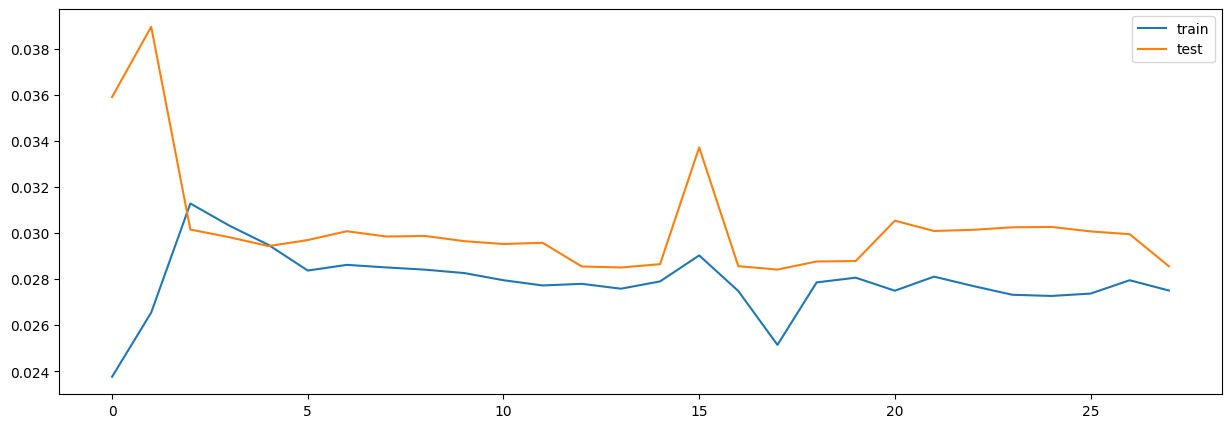

NameError: name 'model' is not defined

In [18]:
# Plot History & Preds for each cluster

for cluster_id, result in results.items():
    print("Cluster_id: {}".format(cluster_id))
    print("MSE Error: {}".format(result['error']))
    # Plot History
    _plot_history(history)

    # Plot Feat Importances
    params = params_df[params_df['cluster_id']==cluster_id]
    sequence_len = params['sequence_len'].values[0]
    _feats_importances(result['test_dataset'], result['feats'], sequence_len)

    # Plot Preds
    _plot_preds(result['preds'], result['test_df'], LABEL_COL)